In [2]:
#tensorflow_text、tensorflow、matplotlib
import numpy as np
import typing
from typing import Any, Tuple
#自定义类型
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
#导入预处理模块
import tensorflow_text as tf_text
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

print("Available GPUs:", tf.config.list_physical_devices('GPU'))
# tf.config.set_visible_devices('/device:GPU:1', 'GPU')


Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [3]:
# tf.config.set_visible_devices('GPU:0', 'GPU')
class ShapeChecker:
    def __init__(self):
        # save every cache
        self.shapes = {}

    def __call__(self, tensor, names, broadcast=False):
        if not tf.executing_eagerly():
            return

        if isinstance(names, str):
            names = (names,)

        shape = tf.shape(tensor)
        rank = tf.rank(tensor)

        if rank != len(names):
            raise ValueError(f'Rank mismatch:\n'
                             f'    found {rank}: {shape.numpy()}\n'
                             f'    expected {len(names)}: {names}\n')

        for i, name in enumerate(names):
            if isinstance(name, int):
                old_dim = name
            else:
                old_dim = self.shapes.get(name, None)
            new_dim = shape[i]

            if broadcast and new_dim == 1:
                continue

            if old_dim is None:
                # if the name is new, save it to the cache
                self.shapes[name] = new_dim
                continue

            if new_dim != old_dim:
                raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                                 f"    found: {new_dim}\n"
                                 f"    expected: {old_dim}\n")


In [4]:
import pathlib

path_to_zip = tf.keras.utils.get_file(
    'cmn-eng.zip', origin='https://www.zhoushicheng.cn/static/cmn-eng.zip',
    extract=True)

path_to_file = pathlib.Path(path_to_zip).parent/'cmn.txt'
print(path_to_file)

/home/zhousc66/.keras/datasets/cmn.txt


In [5]:
import re

def load_data(path):
    # 使用Path读取文本内容
    text = pathlib.Path(path).read_text(encoding='utf-8')

    # 分割成行，并清洗每行数据
    lines = text.splitlines()
    cleaned_lines = [re.split(r'\tCC-BY 2\.0', line)[0] for line in lines]
    
    # 分割每行到英文和中文部分
    pairs = [line.split('\t') for line in cleaned_lines if '\t' in line]
    
    # 分别提取英文和中文数据
    if pairs:  # 确保pairs不为空
        inp, targ = zip(*pairs)  # 解压pairs，获取输入（英文）和目标（中文）
    else:
        inp, targ = [], []
    with open('/home/zhousc66/cmn.txt', 'w', encoding='utf-8') as f:
        for i in range(len(inp)):
            f.write(f"{targ[i]}\t{inp[i]}\n")

    # 修改了这个顺序
    return list(targ), list(inp)

# 使用这个函数，需要指定文件的路径
# 例如:
# english_sentences, chinese_sentences = load_data('path_to_your_file.txt')


In [6]:
import jieba

def process_jieba(text):
    words = jieba.cut(text)
    return ' '.join(words)

In [7]:
inp, targ = load_data(path_to_file)
inp = [process_jieba(text) for text in inp]
print(inp[678])
BUFFER_SIZE = len(inp)
BATCH_SIZE = 64
# create a tf.data.Dataset string to wash the data and batch it efficiently
dataset = tf.data.Dataset.from_tensor_slices((inp, targ)).repeat(5).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.777 seconds.
Prefix dict has been built successfully.


他 生气 了 。


In [65]:
# import jieba
# 
# def process_jieba(text):
#     words = jieba.cut(text)
#     return ' '.join(words)
# example_text = tf.constant('今天天气真不错啊，你感觉呢,我反正是觉得明天后天大后天都挺好的，亲爱的我爱你，想要和你亲亲抱抱举高高，好喜欢宝宝')
example_text = '今天天气真不错啊，你感觉呢,我反正是觉得明天后天大后天都挺好的，亲爱的我爱你，想要和你亲亲抱抱举高高，好喜欢宝宝！'

example_text = tf.constant(process_jieba(example_text))

print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b'\xe4\xbb\x8a\xe5\xa4\xa9\xe5\xa4\xa9\xe6\xb0\x94 \xe7\x9c\x9f\xe4\xb8\x8d\xe9\x94\x99 \xe5\x95\x8a \xef\xbc\x8c \xe4\xbd\xa0 \xe6\x84\x9f\xe8\xa7\x89 \xe5\x91\xa2 , \xe6\x88\x91 \xe5\x8f\x8d\xe6\xad\xa3 \xe6\x98\xaf \xe8\xa7\x89\xe5\xbe\x97 \xe6\x98\x8e\xe5\xa4\xa9 \xe5\x90\x8e\xe5\xa4\xa9 \xe5\xa4\xa7\xe5\x90\x8e\xe5\xa4\xa9 \xe9\x83\xbd \xe6\x8c\xba \xe5\xa5\xbd \xe7\x9a\x84 \xef\xbc\x8c \xe4\xba\xb2\xe7\x88\xb1 \xe7\x9a\x84 \xe6\x88\x91\xe7\x88\xb1\xe4\xbd\xa0 \xef\xbc\x8c \xe6\x83\xb3\xe8\xa6\x81 \xe5\x92\x8c \xe4\xbd\xa0 \xe4\xba\xb2\xe4\xba\xb2 \xe6\x8a\xb1\xe6\x8a\xb1 \xe4\xb8\xbe \xe9\xab\x98\xe9\xab\x98 \xef\xbc\x8c \xe5\xa5\xbd \xe5\x96\x9c\xe6\xac\xa2 \xe5\xae\x9d\xe5\xae\x9d \xef\xbc\x81'
b'\xe4\xbb\x8a\xe5\xa4\xa9\xe5\xa4\xa9\xe6\xb0\x94 \xe7\x9c\x9f\xe4\xb8\x8d\xe9\x94\x99 \xe5\x95\x8a , \xe4\xbd\xa0 \xe6\x84\x9f\xe8\xa7\x89 \xe5\x91\xa2 , \xe6\x88\x91 \xe5\x8f\x8d\xe6\xad\xa3 \xe6\x98\xaf \xe8\xa7\x89\xe5\xbe\x97 \xe6\x98\x8e\xe5\xa4\xa9 \xe5\x90\x8e\xe5\xa4\xa9 \xe5\x

In [66]:
for example_input_batch, example_target_batch in dataset.take(1):
    print(example_input_batch[:5])
    print()
    print(example_target_batch[:5])
    break


tf.Tensor(
[b'\xe6\x88\x91 \xe6\x80\x80\xe5\xad\x95 \xe5\x9b\x9b\xe4\xb8\xaa \xe6\x9c\x88 \xe4\xba\x86 \xe3\x80\x82'
 b'\xe6\x88\x91 \xe4\xb8\x8d \xe6\x87\x92 \xe3\x80\x82'
 b'\xe6\xb1\xa4\xe5\xa7\x86 \xe7\x9a\x84 \xe7\x9c\xbc\xe7\x9d\x9b \xe6\x98\xaf \xe8\x93\x9d\xe8\x89\xb2 \xe7\x9a\x84 \xe3\x80\x82'
 b'\xe5\xae\x83 \xe5\xbe\x88\xe5\xa4\xa7 \xe3\x80\x82'
 b'\xe7\xb3\xbb\xe7\xbb\x9f \xe8\xbf\x90\xe8\xa1\x8c \xe8\xb5\xb7\xe6\x9d\xa5 \xe4\xba\x86 \xe3\x80\x82'], shape=(5,), dtype=string)

tf.Tensor(
[b"I'm four months pregnant." b"I'm not lazy." b"Tom's eyes are blue."
 b"It's very big." b'The system worked.'], shape=(5,), dtype=string)


In [67]:
def tf_lower_and_split_punct(text):
    text = tf_text.normalize_utf8(text, 'NFKD')
    replacements = {
        "，": ",", "。": ".", "：": ":", "；": ";", 
        "？": "?", "！": "!", "‘": "'", "’": "'", 
        "“": '"', "”": '"', "（": "(", "）": ")"
    }
    for src, target in replacements.items():
        text = tf.strings.regex_replace(text, src, target)
    text = tf.strings.lower(text)
    text = tf.strings.regex_replace(text, '[^ a-z\u4e00-\u9fff.?!,]', '')
    text = tf.strings.regex_replace(text, '([.?!,])', r' \1 ')
    text = tf.strings.strip(text)
    
    # jieba 分词
    # text = text.numpy().decode('utf-8')  # 这一步在eager模式下工作，不适用于图模式
    # text = ' '.join(jieba.cut(text))  # 使用jieba分词，并用空格连接成字符串
    
    text = tf.strings.regex_replace(text, r'\s+', ' ')

    # text = tf.convert_to_tensor(text)
    text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
    return text

In [68]:
print(example_text.numpy().decode())
#输出解码结果(德语)
print(tf_lower_and_split_punct(example_text).numpy().decode())


今天天气 真不错 啊 ， 你 感觉 呢 , 我 反正 是 觉得 明天 后天 大后天 都 挺 好 的 ， 亲爱 的 我爱你 ， 想要 和 你 亲亲 抱抱 举 高高 ， 好 喜欢 宝宝 ！
[START] 今天天气 真不错 啊 , 你 感觉 呢 , 我 反正 是 觉得 明天 后天 大后天 都 挺 好 的 , 亲爱 的 我爱你 , 想要 和 你 亲亲 抱抱 举 高高 , 好 喜欢 宝宝 ! [END]


In [12]:
max_vocab_size = 5000

input_text_processor = preprocessing.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size)

In [13]:
input_text_processor.adapt(inp)
# 下是词汇表中的前10个单词:
input_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', '我', '的', '了', '你', '?']

In [14]:
output_text_processor = preprocessing.TextVectorization(
standardize=tf_lower_and_split_punct,
max_tokens=max_vocab_size)
output_text_processor.adapt(targ)
output_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'the', 'i', 'to', 'you', '?']

In [15]:
example_tokens = input_text_processor(example_input_batch)
example_tokens[:3, :10]

<tf.Tensor: shape=(3, 10), dtype=int64, numpy=
array([[   2,  164,  168,  173,    4,    3,    0,    0,    0,    0],
       [   2,  390,   13,    5,   57,   17,  952, 3776,    8,    4],
       [   2,    1,    1,    1,    7,    4,    3,    0,    0,    0]])>

In [16]:
input_vocab = np.array(input_text_processor.get_vocabulary())
tokens = input_vocab[example_tokens[0].numpy()]
' '.join(tokens)


'[START] 你们 必须 回家 . [END]          '

Text(0.5, 1.0, 'Mask')

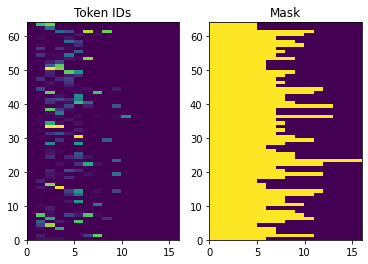

In [17]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens)
plt.title('Token IDs')
plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')


In [18]:
#嵌入维度
embedding_dim = 256
#隐藏单元个数
units = 1024


In [19]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, input_vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        self.enc_units = enc_units
        self.input_vocab_size = input_vocab_size
        # 嵌入层将令牌转换为向量
        self.embedding = tf.keras.layers.Embedding(self.input_vocab_size,
                                                   embedding_dim)
        # GRU RNN层依次处理这些向量。
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, tokens, state=None):
        shape_checker = ShapeChecker()
        shape_checker(tokens, ('batch', 's'))
        # 嵌入层查找每个标记的嵌入情况。
        vectors = self.embedding(tokens)
        shape_checker(vectors, ('batch', 's', 'embed_dim'))
        output, state = self.gru(vectors, initial_state=state)
        shape_checker(output, ('batch', 's', 'enc_units'))
        shape_checker(state, ('batch', 'enc_units'))
        # 返回新的序列和它的状态。
        return output, state


In [20]:
# 将输入的文本转换为token。
example_tokens = input_text_processor(example_input_batch)
# 对输入序列进行编码。
encoder = Encoder(input_text_processor.vocabulary_size(),
                  embedding_dim, units)
example_enc_output, example_enc_state = encoder(example_tokens)
print(f'Input batch, shape (batch): {example_input_batch.shape}')
print(f'Input batch tokens, shape (batch, s): {example_tokens.shape}')
print(f'Encoder output, shape (batch, s, units): {example_enc_output.shape}')
print(f'Encoder state, shape (batch, units): {example_enc_state.shape}')

Input batch, shape (batch): (64,)
Input batch tokens, shape (batch, s): (64, 16)
Encoder output, shape (batch, s, units): (64, 16, 1024)
Encoder state, shape (batch, units): (64, 1024)


In [21]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super().__init__()
        self.W1 = tf.keras.layers.Dense(units, use_bias=False)
        self.W2 = tf.keras.layers.Dense(units, use_bias=False)
        self.attention = tf.keras.layers.AdditiveAttention()

    def call(self, query, value, mask):
        shape_checker = ShapeChecker()
        shape_checker(query, ('batch', 't', 'query_units'))
        shape_checker(value, ('batch', 's', 'value_units'))
        shape_checker(mask, ('batch', 's'))
        # 构建Query矩阵
        w1_query = self.W1(query)
        shape_checker(w1_query, ('batch', 't', 'attn_units'))
        # 构建Key矩阵
        w2_key = self.W2(value)
        shape_checker(w2_key, ('batch', 's', 'attn_units'))
        # 构建mask矩阵
        query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
        value_mask = mask
        # 计算得到注意力图谱
        context_vector, attention_weights = self.attention(
            inputs=[w1_query, value, w2_key],
            mask=[query_mask, value_mask],
            return_attention_scores=True,
        )
        shape_checker(context_vector, ('batch', 't', 'value_units'))
        shape_checker(attention_weights, ('batch', 't', 's'))
        return context_vector, attention_weights

In [22]:
# test attention
# 创建一个BahdanauAttention层
attention_layer = BahdanauAttention(units)
# 后续解码器将产生这个attention查询(Query矩阵)
example_attention_query = tf.random.normal(shape=[len(example_tokens), 2, 10])
# 添加到编码tokens
context_vector, attention_weights = attention_layer(
    query=example_attention_query,
    value=example_enc_output,
    mask=(example_tokens != 0))

print(f'Attention result shape: (batch_size, query_seq_length, units): {context_vector.shape}')

print(f'Attention weights shape: (batch_size, query_seq_length,value_seq_length): {attention_weights.shape}')

Attention result shape: (batch_size, query_seq_length, units): (64, 2, 1024)
Attention weights shape: (batch_size, query_seq_length,value_seq_length): (64, 2, 16)


Text(0.5, 1.0, 'Mask')

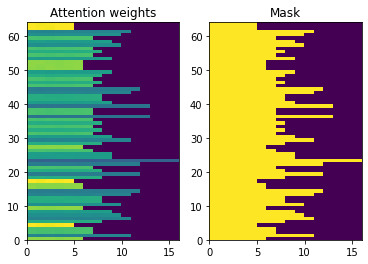

In [23]:
plt.subplot(1, 2, 1)
plt.pcolormesh(attention_weights[:, 0, :])
plt.title('Attention weights')
plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')
# 输出结果：
# Text(0.5, 1.0, 'Mask')

<Figure size 432x288 with 0 Axes>

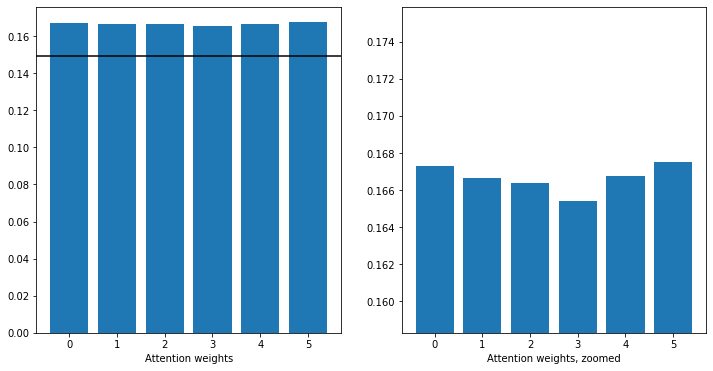

In [24]:
#取出部分attention用于展示
attention_slice = attention_weights[0, 0].numpy()
attention_slice = attention_slice[attention_slice != 0]
plt.suptitle('Attention weights for one sequence')
plt.figure(figsize=(12, 6))
a1 = plt.subplot(1, 2, 1)
plt.bar(range(len(attention_slice)), attention_slice)
# 固定x轴
plt.xlim(plt.xlim())
plt.xlabel('Attention weights')
a2 = plt.subplot(1, 2, 2)
plt.bar(range(len(attention_slice)), attention_slice)
plt.xlabel('Attention weights, zoomed')
# 放大结果
top = max(a1.get_ylim())
zoom = 0.85 * top
a2.set_ylim([0.90 * top, top])
a1.plot(a1.get_xlim(), [zoom, zoom], color='k')


# 输出结果：
# [<matplotlib.lines.Line2D at 0x20c356a9670>]
# <Figure size 432x288 with 0 Axes>

In [25]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, output_vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.output_vocab_size = output_vocab_size
        self.embedding_dim = embedding_dim

        # 嵌入层将令牌ID转为向量
        self.embedding = tf.keras.layers.Embedding(self.output_vocab_size,
                                                   embedding_dim)
        # RNN会记录到目前为止已经生成的内容。
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        # RNN的输出将是注意力层的查询。
        self.attention = BahdanauAttention(self.dec_units)
        self.Wc = tf.keras.layers.Dense(dec_units, activation=tf.math.tanh,
                                        use_bias=False)
        self.fc = tf.keras.layers.Dense(self.output_vocab_size)

In [26]:
class DecoderInput(typing.NamedTuple):
    new_tokens: Any
    enc_output: Any
    mask: Any


class DecoderOutput(typing.NamedTuple):
    logits: Any
    attention_weights: Any

In [27]:
def call(self,
         inputs: DecoderInput,
         state=None) -> Tuple[DecoderOutput, tf.Tensor]:
    shape_checker = ShapeChecker()
    shape_checker(inputs.new_tokens, ('batch', 't'))
    shape_checker(inputs.enc_output, ('batch', 's', 'enc_units'))
    shape_checker(inputs.mask, ('batch', 's'))
    if state is not None:
        shape_checker(state, ('batch', 'dec_units'))
    #查询词嵌入
    vectors = self.embedding(inputs.new_tokens)
    shape_checker(vectors, ('batch', 't', 'embedding_dim'))
    #用RNN处理一个步骤
    rnn_output, state = self.gru(vectors, initial_state=state)
    shape_checker(rnn_output, ('batch', 't', 'dec_units'))
    shape_checker(state, ('batch', 'dec_units'))
    #使用RNN输出作为关注的查询，超过了编码器的输出。

    context_vector, attention_weights = self.attention(
        query=rnn_output, value=inputs.enc_output, mask=inputs.mask)
    shape_checker(context_vector, ('batch', 't', 'dec_units'))
    shape_checker(attention_weights, ('batch', 't', 's'))
    # 加入context_vector和rnn_output
    context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)
    attention_vector = self.Wc(context_and_rnn_output)
    shape_checker(attention_vector, ('batch', 't', 'dec_units'))
    # 生成logit预测
    logits = self.fc(attention_vector)
    shape_checker(logits, ('batch', 't', 'output_vocab_size'))
    return DecoderOutput(logits, attention_weights), state

In [28]:
Decoder.call = call
decoder = Decoder(output_text_processor.vocabulary_size(),
                  embedding_dim, units)

In [29]:

#转换目标序列，并收集[START]标记。
example_output_tokens = output_text_processor(example_target_batch)
start_index = output_text_processor.get_vocabulary().index('[START]')
first_token = tf.constant([[start_index]] * example_output_tokens.shape[0])

In [30]:
#运行decoder
dec_result, dec_state = decoder(
    inputs=DecoderInput(new_tokens=first_token,
                        enc_output=example_enc_output,
                        mask=(example_tokens != 0)),
    state=example_enc_state
)
print(f'logits shape: (batch_size, t, output_vocab_size)'
      f'{dec_result.logits.shape}')
print(f'state shape: (batch_size, dec_units) {dec_state.shape}')

logits shape: (batch_size, t, output_vocab_size)(64, 1, 5000)
state shape: (batch_size, dec_units) (64, 1024)


In [31]:
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)
#将令牌解码为输出的第一个单词。
vocab = np.array(output_text_processor.get_vocabulary())
first_word = vocab[sampled_token.numpy()]
print(first_word[:5])

[['supplies']
 ['whoever']
 ['died']
 ['hungry']
 ['mall']]


In [32]:
dec_result, dec_state = decoder(
    DecoderInput(sampled_token,
                 example_enc_output,
                 mask=(example_tokens != 0)),
    state=dec_state)
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)
first_word = vocab[sampled_token.numpy()]
print(first_word[:5])

[['tells']
 ['amassed']
 ['stick']
 ['fallen']
 ['resigning']]


In [33]:
class MaskedLoss(tf.keras.losses.Loss):
    def __init__(self):
        self.name = 'masked_loss'
        self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True, reduction='none')

    def __call__(self, y_true, y_pred):
        shape_checker = ShapeChecker()
        shape_checker(y_true, ('batch', 't'))
        shape_checker(y_pred, ('batch', 't', 'logits'))
        # 计算该批次中每一项的损失。
        loss = self.loss(y_true, y_pred)
        shape_checker(loss, ('batch', 't'))
        # 屏蔽掉填充物上的损失。
        mask = tf.cast(y_true != 0, tf.float32)
        shape_checker(mask, ('batch', 't'))
        loss *= mask
        # 返回总的loss。
        return tf.reduce_sum(loss)

In [34]:
class TrainTranslator(tf.keras.Model):
    def __init__(self, embedding_dim, units,
                 input_text_processor,
                 output_text_processor,
                 use_tf_function=True):
        super().__init__()

        # 构建编码器和解码器
        encoder = Encoder(input_text_processor.vocabulary_size(),
                          embedding_dim, units)
        decoder = Decoder(output_text_processor.vocabulary_size(),
                          embedding_dim, units)
        self.encoder = encoder
        self.decoder = decoder
        self.input_text_processor = input_text_processor
        self.output_text_processor = output_text_processor
        self.use_tf_function = use_tf_function
        self.shape_checker = ShapeChecker()

    def train_step(self, inputs):
        self.shape_checker = ShapeChecker()

        if self.use_tf_function:
            return self._tf_train_step(inputs)
        else:
            return self._train_step(inputs)

In [35]:
def _preprocess(self, input_text, target_text):
    self.shape_checker(input_text, ('batch',))
    self.shape_checker(target_text, ('batch',))
    # 将文本转换为tokens ID
    input_tokens = self.input_text_processor(input_text)
    target_tokens = self.output_text_processor(target_text)
    self.shape_checker(input_tokens, ('batch', 's'))
    self.shape_checker(target_tokens, ('batch', 't'))
    # 将ID转换为掩码
    input_mask = input_tokens != 0
    self.shape_checker(input_mask, ('batch', 's'))
    target_mask = target_tokens != 0

    self.shape_checker(target_mask, ('batch', 't'))
    return input_tokens, input_mask, target_tokens, target_mask


TrainTranslator._preprocess = _preprocess

In [36]:
def _train_step(self, inputs):
    input_text, target_text = inputs
    (input_tokens, input_mask,
     target_tokens, target_mask) = self._preprocess(input_text, target_text)
    max_target_length = tf.shape(target_tokens)[1]
    with tf.GradientTape() as tape:
        #对输入进行编码
        enc_output, enc_state = self.encoder(input_tokens)
        self.shape_checker(enc_output, ('batch', 's', 'enc_units'))
        self.shape_checker(enc_state, ('batch', 'enc_units'))
        #将解码器的状态初始化为编码器的最终状态。
        # 这只有在编码器和解码器有相同数量的单位时生效。
        dec_state = enc_state
        loss = tf.constant(0.0)
        for t in tf.range(max_target_length - 1):
            #从目标序列中传入两个token:
            # 1.解码器的当前输入.
            # 2.解码器下次预测的目标.
            new_tokens = target_tokens[:, t:t + 2]
            step_loss, dec_state = self._loop_step(new_tokens, input_mask,
                                                   enc_output, dec_state)
            loss = loss + step_loss
        #对所有非填充token的损失进行平均计算。
        average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))
    #设置优化步骤
    variables = self.trainable_variables
    gradients = tape.gradient(average_loss, variables)
    self.optimizer.apply_gradients(zip(gradients, variables))
    # 返回一个映射到当前值的字典
    return {'batch_loss': average_loss}


TrainTranslator._train_step = _train_step

In [37]:
def _loop_step(self, new_tokens, input_mask, enc_output, dec_state):
    input_token, target_token = new_tokens[:, 0:1], new_tokens[:, 1:2]
    # Run the decoder one step.
    decoder_input = DecoderInput(new_tokens=input_token,
                                 enc_output=enc_output,
                                 mask=input_mask)
    dec_result, dec_state = self.decoder(decoder_input, state=dec_state)
    self.shape_checker(dec_result.logits, ('batch', 't1', 'logits'))
    self.shape_checker(dec_result.attention_weights, ('batch', 't1', 's'))
    self.shape_checker(dec_state, ('batch', 'dec_units'))
    # `self.loss`返回非填充token的总数。
    y = target_token
    y_pred = dec_result.logits
    step_loss = self.loss(y, y_pred)
    return step_loss, dec_state

In [38]:
TrainTranslator._loop_step = _loop_step

translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
    use_tf_function=False)
#配置损失和优化器
translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

In [39]:
np.log(output_text_processor.vocabulary_size())
# 输出结果:
# 8.517193191416238

8.517193191416238

In [40]:
%%time
for n in range(10):
    print(translator.train_step([example_input_batch, example_target_batch]))
print()


# 输出结果:
# {'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.6101117>}
# {'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.5797815>}
# {'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.522971>}
# {'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.3605533>}
# {'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.785821>}
# {'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.0904937>}
# {'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.8641896>}
# {'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.3120656>}
# {'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.264642>}
# {'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.112561>}

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.6160154>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.5838037>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.523865>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.3563976>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.786584>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.129418>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.2127132>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.432586>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.1922345>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.098165>}

CPU times: user 4.77 s, sys: 0 ns, total: 4.77 s
Wall time: 4.71 s


In [41]:
@tf.function(input_signature=[[tf.TensorSpec(dtype=tf.string, shape=[None]),
                               tf.TensorSpec(dtype=tf.string, shape=[None])]])
def _tf_train_step(self, inputs):
    return self._train_step(inputs)


TrainTranslator._tf_train_step = _tf_train_step

translator.use_tf_function = True
#第一次运行由于需要对函数进行追踪，故速度会比较慢
translator.train_step([example_input_batch, example_target_batch])

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.072269>}

```python
%%time
for n in range(10):
    print(translator.train_step([example_input_batch, example_target_batch]))
print()
```

....................................................................................................
CPU times: user 1min 20s, sys: 8.01 s, total: 1min 28s
Wall time: 28.7 s


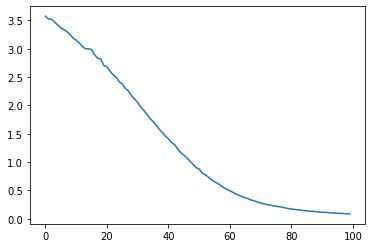

In [43]:
%%time
losses = []
for n in range(100):
    print('.', end='')
    logs = translator.train_step([example_input_batch, example_target_batch])
    losses.append(logs['batch_loss'].numpy())
print()
plt.plot(losses)
# 输出结果:
#
# [<matplotlib.lines.Line2D at 0x20c362c3c70>]

In [44]:
train_translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor)
# Configure the loss and optimizer
train_translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

In [45]:
class BatchLogs(tf.keras.callbacks.Callback):
    def __init__(self, key):
        self.key = key
        self.logs = []

    def on_train_batch_end(self, n, logs):
        self.logs.append(logs[self.key])


batch_loss = BatchLogs('batch_loss')

train_translator.fit(dataset, epochs=4,
                     # steps_per_epoch=100,
                     callbacks=[batch_loss])

Epoch 1/4
2337/2337 [==============================] - 671s 285ms/step - batch_loss: 1.9208
Epoch 2/4
2337/2337 [==============================] - 667s 286ms/step - batch_loss: 0.4853
Epoch 3/4
2337/2337 [==============================] - 664s 284ms/step - batch_loss: 0.2068
Epoch 4/4
2337/2337 [==============================] - 664s 284ms/step - batch_loss: 0.1758


Text(0, 0.5, 'CE/token')

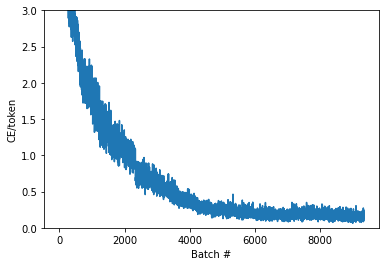

In [46]:
# 如果上一个cell中的epoches和steps_per_epoch过小，此处没有绘图效果。
plt.plot(batch_loss.logs)
plt.ylim([0, 3])
plt.xlabel('Batch #')
plt.ylabel('CE/token')

In [47]:
class Translator(tf.Module):
    def __init__(self, encoder, decoder, input_text_processor,
                 output_text_processor):
        self.encoder = encoder
        self.decoder = decoder
        self.input_text_processor = input_text_processor
        self.output_text_processor = output_text_processor
        self.output_token_string_from_index = (
            tf.keras.layers.experimental.preprocessing.StringLookup(
                vocabulary=output_text_processor.get_vocabulary(),
                mask_token='',
                invert=True))

        # 输出不应该产生padding、unknown或start。
        index_from_string = tf.keras.layers.experimental.preprocessing.StringLookup(
            vocabulary=output_text_processor.get_vocabulary(), mask_token='')
        token_mask_ids = index_from_string(['', '[UNK]', '[START]']).numpy()
        token_mask = np.zeros([index_from_string.vocabulary_size()], dtype=np.bool)

        token_mask[np.array(token_mask_ids)] = True
        self.token_mask = token_mask
        self.start_token = index_from_string(tf.constant('[START]'))
        self.end_token = index_from_string(tf.constant('[END]'))


translator = Translator(
    encoder=train_translator.encoder,
    decoder=train_translator.decoder,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
)

In [48]:
def tokens_to_text(self, result_tokens):
    shape_checker = ShapeChecker()
    shape_checker(result_tokens, ('batch', 't'))
    result_text_tokens = self.output_token_string_from_index(result_tokens)
    shape_checker(result_text_tokens, ('batch', 't'))
    result_text = tf.strings.reduce_join(result_text_tokens,
                                         axis=1, separator=' ')
    shape_checker(result_text, 'batch')
    result_text = tf.strings.strip(result_text)
    shape_checker(result_text, ('batch',))
    return result_text


Translator.tokens_to_text = tokens_to_text

example_output_tokens = tf.random.uniform(
    shape=[5, 2], minval=0, dtype=tf.int64,
    maxval=output_text_processor.vocabulary_size())

translator.tokens_to_text(example_output_tokens).numpy()

array([b'stop someday', b'forewarned worsening', b'ceases knocking',
       b'strongly ignorant', b'towel loses'], dtype=object)

In [49]:
def sample(self, logits, temperature):
    shape_checker = ShapeChecker()
    shape_checker(logits, ('batch', 't', 'vocab'))
    shape_checker(self.token_mask, ('vocab',))
    token_mask = self.token_mask[tf.newaxis, tf.newaxis, :]
    shape_checker(token_mask, ('batch', 't', 'vocab'), broadcast=True)
    logits = tf.where(self.token_mask, -np.inf, logits)
    if temperature == 0.0:
        new_tokens = tf.argmax(logits, axis=-1)
    else:
        logits = tf.squeeze(logits, axis=1)
        new_tokens = tf.random.categorical(logits / temperature,
                                           num_samples=1)
        shape_checker(new_tokens, ('batch', 't'))
        return new_tokens

Translator.sample = sample

example_logits = tf.random.normal([5, 1,
                                   output_text_processor.vocabulary_size()])
example_output_tokens = translator.sample(example_logits, temperature=1.0)
example_output_tokens

<tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[1533],
       [4481],
       [3891],
       [ 566],
       [2906]])>

In [50]:
def translate_unrolled(self,
                       input_text, *,
                       max_length=50,
                       return_attention=True,
                       temperature=1.0):
    batch_size = tf.shape(input_text)[0]
    input_tokens = self.input_text_processor(input_text)
    enc_output, enc_state = self.encoder(input_tokens)
    dec_state = enc_state
    new_tokens = tf.fill([batch_size, 1], self.start_token)
    result_tokens = []
    attention = []
    done = tf.zeros([batch_size, 1], dtype=tf.bool)
    for _ in range(max_length):
        dec_input = DecoderInput(new_tokens=new_tokens,
                                 enc_output=enc_output,
                                 mask=(input_tokens != 0))
        dec_result, dec_state = self.decoder(dec_input, state=dec_state)
        attention.append(dec_result.attention_weights)
        new_tokens = self.sample(dec_result.logits, temperature)
        done = done | (new_tokens == self.end_token)
        # 一旦一个序列完成，它只产生0-padding。
        new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)
        result_tokens.append(new_tokens)
        if tf.executing_eagerly() and tf.reduce_all(done):
            break
    # 将生成的token id列表转换为字符串列表。

    result_tokens = tf.concat(result_tokens, axis=-1)
    result_text = self.tokens_to_text(result_tokens)
    if return_attention:
        attention_stack = tf.concat(attention, axis=1)
        return {'text': result_text, 'attention': attention_stack}
    else:
        return {'text': result_text}

In [51]:
Translator.translate = translate_unrolled

In [63]:
%%time
def jieba_tokenize(inputtext):
    return ' '.join(jieba.cut(inputtext))

raw_input_texts = [
    '你很漂亮.',
    '我想和你睡觉',
]

tokenized_inputs = [jieba_tokenize(text) for text in raw_input_texts]
input_text = tf.constant(tokenized_inputs)
result = translator.translate(
    input_text=input_text)

# print(result)
print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()
# 实验结果:
# it is very cold here .
# this is my life .
# Wall time: 266 ms


youre very beautiful .
i want to go to bed with you .

CPU times: user 228 ms, sys: 3.11 ms, total: 231 ms
Wall time: 219 ms
